# Experiment with extracting shape info from confocal images of fish embryos

In [ ]:
from aicsimageio import AICSImage
import os 
import glob2 as glob
import numpy as np
from matplotlib import pyplot as plt

image_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/20230412/timeseries.nd2"
imObject = AICSImage(image_path)

imObject.set_scene("XYPos:17")
n_time_points = imObject.dims["T"][0]
res_raw = imObject.physical_pixel_sizes
res_array = np.asarray(res_raw)

# generate and save depth image
n_time_points = imObject.dims["T"][0]

# im_array = np.empty((n_time_points, 317*818))
for t in [0]:#range(n_time_points):

    # extract image
    imData = np.squeeze(imObject.get_image_data("CZYX", T=t))
    imData_rs = scipy.ndimage.zoom(imData, [1, 1/4, 1/4])
    
    z_grid3, _, _ = np.meshgrid(range(0, imData_rs.shape[0]), 
                                        range(0, imData_rs.shape[1]), 
                                        range(0, imData_rs.shape[2]),
                                       indexing="ij")
    
    max_z_plane = np.argmax(imData_rs, axis=0)
    
    plt.imshow(max_z_plane)
#     im_array[t, :] = max_z_plane.flatten()

In [14]:
res_array

array([20.        ,  1.08619834,  1.08619834])

In [8]:
import umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
# apply UMAP dimensionality reduction (why not?)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(im_array)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter(embedding[:, 0], embedding[:, 1], color=range(n_time_points))
fig.show()

/var/folders/m7/tpjttxb92tl8b4c9svgvgby00000gn/T/ipykernel_17883/2133732450.py:8: RuntimeWarning: invalid value encountered in divide
  mean_z_plane = np.divide(np.sum(np.multiply(imData, z_grid3), axis=0), np.sum(imData, axis=0))


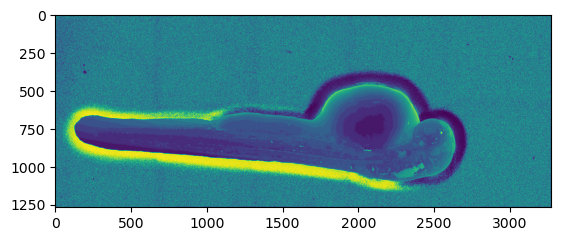

In [78]:
from matplotlib import pyplot as plt

z_grid3, y_grid3, x_grid3 = np.meshgrid(range(0, imData.shape[0]), 
                                        range(0, imData.shape[1]), 
                                        range(0, imData.shape[2]),
                                        indexing="ij")

mean_z_plane = np.divide(np.sum(np.multiply(imData, z_grid3), axis=0), np.sum(imData, axis=0))
maxmean_z_plane = mean_z_plane.astype(float)

max_z_plane = np.argmax(imData, axis=0)

plt.imshow(max_z_plane)

In [81]:
import umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
# apply UMAP dimensionality reduction (why not?)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(max_z_plane.flatten())

AttributeError: module 'umap' has no attribute 'UMAP'

Attempt to infer a surface using marching cubes

**Can we use linear interpolation to fill label gaps?**

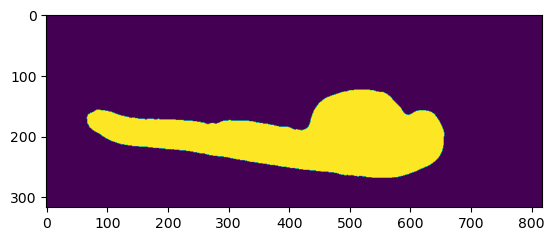

In [70]:
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)

# first, generate 3D mask to identify interior pixels that we wish to interpolate
fish_mask = (np.max(labelDataBin, axis=0) == 1)*1

# use morphological closure operation to fill in shape
footprint = disk(8)
fp_small = disk(2)
fish_closed = closing(fish_mask > 0, footprint)
fish_clean = skimage.morphology.remove_small_objects(label(fish_closed), min_size=64)
fish_eroded = skimage.morphology.binary_erosion(fish_clean, fp_small)
# plt.imshow(fish_mask)
plt.imshow(fish_clean)

Use known z label locations to interpolate missing ones

In [71]:
from scipy.interpolate import LinearNDInterpolator

y_grid2, x_grid2 = np.meshgrid(
                                range(0, max_z_plane.shape[0]), 
                                range(0, max_z_plane.shape[1]),
                                indexing="ij")

x_flat = x_grid2.flatten()
y_flat = y_grid2.flatten()

# generate diplacement vectors
max_z_plane_vals = max_z_plane.flatten()
mask_flat = (fish_clean.flatten() > 0)*1
mask_er = (fish_eroded.flatten() > 0)*1

ref_x = x_flat[np.where((~np.isnan(max_z_plane_vals)) & (mask_flat==1))]
ref_y = y_flat[np.where((~np.isnan(max_z_plane_vals)) & (mask_flat==1))]
ref_z = max_z_plane_vals[np.where((~np.isnan(max_z_plane_vals)) & (mask_flat==1))]

query_x = x_flat[np.where(mask_flat==1)]
query_y = y_flat[np.where(mask_flat==1)]
query_x_er = x_flat[np.where(mask_er==1)]
query_y_er = y_flat[np.where(mask_er==1)]

# interpolate
interp_z = LinearNDInterpolator(list(zip(ref_x, ref_y)), ref_z)
query_z = interp_z(query_x, query_y)
            

# disp_x = interp_x(source_xyz_norm[:, 0], source_xyz_norm[:, 1], source_xyz_norm[:, 2])
# disp_y = interp_y(source_xyz_norm[:, 0], source_xyz_norm[:, 1], source_xyz_norm[:, 2])
# disp_z = interp_z(source_xyz_norm[:, 0], source_xyz_norm[:, 1], source_xyz_norm[:, 2])

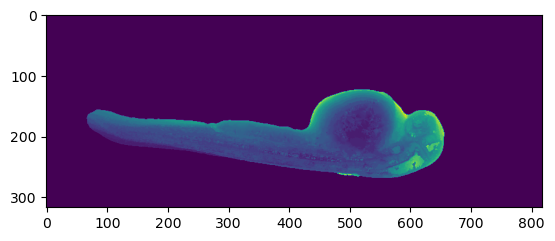

In [72]:
surf_mask_array_raw = np.zeros(labelData_rs.shape)
surf_mask_array_raw[np.round(query_z).astype(int), query_y, query_x] = 1

surf_mask_array = surf_mask_array_raw.copy() 
# surf_mask_array[40, query_y_er, query_x_er] = 1

plt.imshow(np.argmax(surf_mask_array, axis=0))

Maybe alphashape?

In [73]:
from alphashape import alphashape
import open3d as o3d
z_flat = max_z_plane.flatten()
plot_x = x_flat[np.where((~np.isnan(max_z_plane_vals)))]
plot_y = y_flat[np.where((~np.isnan(max_z_plane_vals)))]
plot_z = z_flat[np.where((~np.isnan(max_z_plane_vals)))]

surf_flat = surf_mask_array.flatten()
keep_indices = np.where(surf_mask_array>0)
# x3 = x_grid3[keep_indices]
# y3 = y_grid3[keep_indices]
# z3 = z_grid3[keep_indices]
# generate smooth bottom
base_array = np.empty((len(plot_x), 3))
base_array[:, 0] = plot_x
base_array[:, 1] = plot_y
base_array[:, 2] = plot_z + 10

xyz_array3 = np.concatenate((plot_x[:, np.newaxis], plot_y[:, np.newaxis], plot_z[:, np.newaxis]), axis=1)
# xyz_array3 = np.concatenate((x_surf3[:, np.newaxis], y_surf3[:, np.newaxis], z_surf3[:, np.newaxis]), axis=1)
xyz_array3 = np.concatenate((xyz_array3, base_array), axis=0)
xyz_array3_norm = xyz_array3.copy()
xyz_array3_norm = xyz_array3_norm / np.max(xyz_array3_norm)

print(xyz_array3_norm.shape)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_array3_norm)
pcd_ds = pcd.voxel_down_sample(voxel_size=0.0001)

xyz_ds = np.asarray(pcd_ds.points)
print(xyz_ds.shape)
alpha_fish = alphashape(xyz_ds, alpha=50)
alpha_fish.show()

(76030, 3)
(76030, 3)


22-Apr-23 17:08:03 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
22-Apr-23 17:08:03 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
22-Apr-23 17:08:03 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
22-Apr-23 17:08:04 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
22-Apr-23 17:08:04 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
22-Apr-23 17:08:04 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
22-Apr-23 17:08:04 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
22-Apr-23 17:08:04 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
22-Apr-23 17:08:05 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
2

Well...let's try a different method

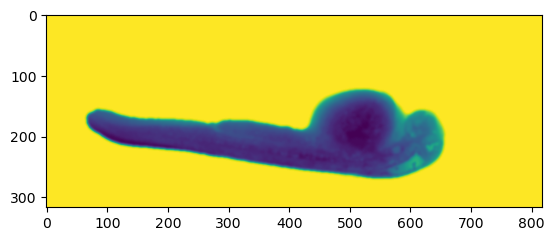

In [74]:
from skimage.filters import gaussian

surf_mask_array_smooth = np.argmax(surf_mask_array_raw.copy(), axis=0)
surf_mask_array_smooth[np.where(surf_mask_array_smooth==0)] = 84
surf_mask_array_smooth = gaussian(surf_mask_array_smooth, sigma=2, preserve_range=True)
plt.imshow(surf_mask_array_smooth)
new_z = surf_mask_array_smooth[query_y_er, query_x_er]

In [75]:
xyz_array = np.concatenate((query_x_er[:, np.newaxis], query_y_er[:, np.newaxis], new_z[:, np.newaxis]), axis=1)

base_array = np.empty((len(query_x_er), 3))
base_array[:, 0] = query_x_er
base_array[:, 1] = query_y_er
base_array[:, 2] = new_z + 20

# xyz_array3 = np.concatenate((plot_x[:, np.newaxis], plot_y[:, np.newaxis], plot_z[:, np.newaxis]), axis=1)
# xyz_array3 = np.concatenate((x_surf3[:, np.newaxis], y_surf3[:, np.newaxis], z_surf3[:, np.newaxis]), axis=1)
xyz_array3 = np.concatenate((xyz_array, base_array), axis=0)
xyz_array3_norm = xyz_array3.copy()
xyz_array3_norm = xyz_array3_norm / np.max(xyz_array3_norm)

print(xyz_array3_norm.shape)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_array3_norm)
pcd_ds = pcd.voxel_down_sample(voxel_size=0.0001)
cl, ind = pcd_ds.remove_statistical_outlier(nb_neighbors=20,
                                                        std_ratio=2.0)

xyz_ds = np.asarray(pcd_ds.points)
print(xyz_ds.shape)
alpha_fish = alphashape(xyz_ds[ind], alpha=50)
alpha_fish.show()

(86206, 3)
(86206, 3)


In [46]:
alpha_fish

<trimesh.Trimesh(vertices.shape=(2330, 3), faces.shape=(4656, 3))>

In [143]:
import pyvista as pv
import open3d as o3d

xyz_array = np.concatenate((query_x_er[:, np.newaxis], query_y_er[:, np.newaxis], new_z[:, np.newaxis]), axis=1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_array)
pcd_ds = pcd.voxel_down_sample(voxel_size=1)

xyz_ds = np.asarray(pcd_ds.points)
pv_cloud = pv.PolyData(xyz_ds)
print(xyz_ds.shape)
print(xyz_array.shape)


alpha = 10
dl_3d_mesh = pv_cloud.delaunay_2d(alpha=alpha)
# # dl_3d_mesh = alphashape.alphashape(xyz_in, alpha=8)
# dl_3d_mesh.fill_holes(200, inplace=True)
smooth = dl_3d_mesh.smooth_taubin(n_iter=5000)
smooth.plot(jupyter_backend='ipygany', scalars=xyz_ds[:, 2])

(49272, 3)
(49272, 3)


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options=(('BrBG'…

In [46]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

In [47]:
(mnist.data.shape)

(70000, 784)

(array([[  1.3463652,  46.780983 ,  22.672756 ],
        [  1.8602695,  46.668724 ,  23.168442 ],
        [  1.5820512,  47.105965 ,  22.951086 ],
        ...,
        [ 40.5      , 130.       , 243.       ],
        [ 40.499744 , 129.98375  , 248.0003   ],
        [ 40.499638 , 129.98549  , 250.00023  ]], dtype=float32),
 array([[   2,    1,    0],
        [   2,    0,    3],
        [   4,    0,    1],
        ...,
        [2177, 2131, 2129],
        [2185, 2183, 2237],
        [2184, 2237, 2183]]))
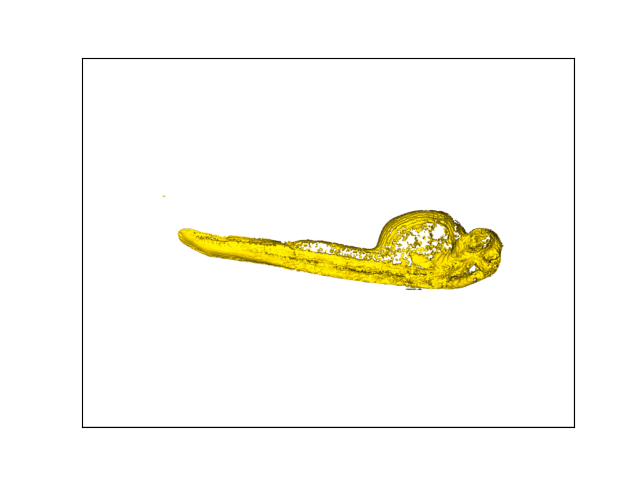

In [11]:
nppas.fill_holes_in_surface(smoothed_surface, size_limit=300)

(array([[  2.8944879,  89.52143  , 266.86444  ],
        [  2.6492836,  93.284424 , 271.37393  ],
        [  2.0208771,  94.426254 , 267.82535  ],
        ...,
        [ 35.18774  , 103.28049  , 318.88617  ],
        [ 33.28581  , 106.40932  , 320.48843  ],
        [ 37.313377 , 105.401405 , 314.73264  ]], dtype=float32),
 array([[  0,   1,   2],
        [  3,   4,   5],
        [  6,   7,   8],
        ...,
        [796, 794, 792],
        [791, 795, 794],
        [796, 791, 794]]))
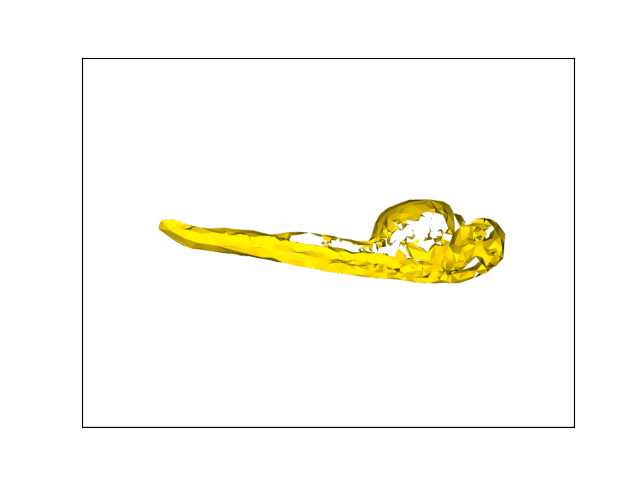

In [31]:
simplified_surface2 = nppas.decimate_quadric(smoothed_surface, fraction=0.01)
simplified_surface2

**Let's see if we can fill gaps using linear interpolation**

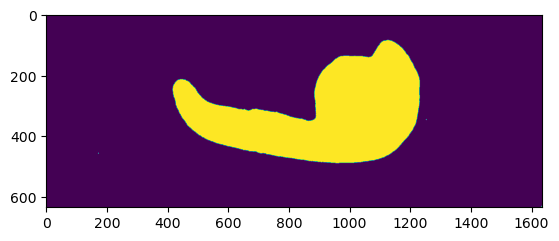

In [36]:
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)

# first, generate 3D mask to identify interior pixels that we wish to interpolate
fish_mask = (np.max(imDataBin, axis=0) == 1)*1

# use morphological closure operation to fill in shape
footprint = disk(15)
fish_closed = closing(fish_mask, footprint)

# plt.imshow(fish_mask)
plt.imshow(fish_closed)


In [ ]:
from scipy import interpolate

# identify "holes" for which not a single pixel nonzero exists 
query_indices = np.where((fish_closed==1) & (fish_mask!=1))[0]
ref_indices = np.where(fish_mask==1)[0]
print(len(candidate_indices))
print(len(ref_indices))

f = interpolate.interp2d(xyz_array2[:, 0], xyz_array2[:, 1], xyz_array2[:, 2], kind='linear')
x_query = x_grid2[query_indices]
y_query = y_grid2[query_indices]
z_query = f(x_query, y_query)

Try fitting to the surface points only

(array([[0.0000e+00, 6.2950e+02, 1.6340e+03],
        [5.0000e-01, 6.3000e+02, 1.6340e+03],
        [0.0000e+00, 6.3000e+02, 1.6335e+03],
        ...,
        [1.6900e+02, 3.9800e+02, 1.1795e+03],
        [1.6900e+02, 3.9800e+02, 1.1805e+03],
        [1.6900e+02, 3.9850e+02, 1.1800e+03]], dtype=float32),
 array([[     2,      1,      0],
        [     1,      3,      0],
        [     5,      4,      1],
        ...,
        [536716, 536713, 536714],
        [536717, 536715, 536713],
        [536717, 536713, 536716]]))
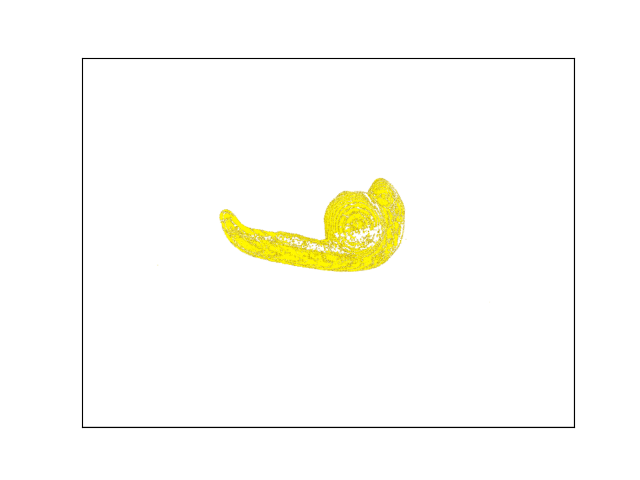

In [24]:
surf_mask_array = np.zeros(imData_rs.shape)
sub_i = np.roll(xyz_array2, 1, axis=1)
surf_indices = np.ravel_multi_index((1,2,2), imData_rs.shape)
surf_mask_array[xyz_array2[:, 2], xyz_array2[:, 1], xyz_array2[:, 0]] = 1

e_surf = nppas.all_labels_to_surface(surf_mask_array)
e_surf

In [30]:
e_surf.__dict__.keys()

dict_keys(['library_name', 'help_url'])

**Attempt 2:** downsample, interpolate, and then infer mesh

In [ ]:
# import numpy as np
# import scipy
# from scipy import interpolate


# f = interpolate.interp2d(xyz_ds_in[:, 0], xyz_ds_in[:, 1], xyz_ds_in[:, 2], kind='linear')


In [ ]:
# npoints = 150
# xg = np.linspace(np.min(xyz_ds_in[:, 0]), np.max(xyz_ds_in[:, 0]), npoints)
# yg = np.linspace(np.min(xyz_ds_in[:, 1]), np.max(xyz_ds_in[:, 1]), npoints)

# x_grid, y_grid = np.meshgrid(xg, yg)

# znew = f(xg, yg)

# xyz_interp = np.concatenate((np.reshape(x_grid, (x_grid.size, 1)), 
#                              np.reshape(y_grid, (x_grid.size, 1)),
#                              np.reshape(znew, (x_grid.size, 1))),
#                              axis=1)

# xyz_interp_filt = xyz_interp[np.where(xyz_interp[:, 2]<=350)]
# xyz_interp_filt = xyz_interp_filt[xyz_interp_filt[:, 2]>0]
# pv_cloud_interp = pv.PolyData(xyz_interp_filt)
# pv_cloud_interp.plot(jupyter_backend='ipygany')